### Import

In [426]:
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

#plot
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

#technical analysis
import ta
import ta.momentum
import ta.volatility
import ta.volume

#### Ignore warnings

In [427]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

In [428]:
# df = pd.read_csv("./data/nasdaq/csv/.csv", sep=',')
df = pd.read_csv("./data/nyse/csv/x.csv", sep=',')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.index = range(len(df))

df.tail()
df.set_index('Date', inplace=True)

all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
df = df.reindex(all_dates) 
df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']] = df[['Low', 'Open', 'Volume', 'High', 'Close', 'Adjusted Close']].interpolate(method='linear')
df['Open'] = df['Close'].shift(1)
df['High'] = df[['High', 'Open', 'Close']].max(axis=1)
df['Low'] = df[['Low', 'Open', 'Close']].min(axis=1)
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)

### Add technical analysis indicators

#### RSI - Relative Strength Index

In [429]:
df['RSI7'] = ta.momentum.RSIIndicator(df['Close'], window=7).rsi()
df['RSI14'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()
df['RSI30'] = ta.momentum.RSIIndicator(df['Close'], window=30).rsi()
df['RSI50'] = ta.momentum.RSIIndicator(df['Close'], window=50).rsi()

# df['MEAN_RSI7_5'] = df['RSI7'].rolling(window=5).mean()
# df['MEAN_RSI14_5'] = df['RSI14'].rolling(window=5).mean()
# df['MEAN_RSI30_5'] = df['RSI30'].rolling(window=5).mean()
# df['MEAN_RSI50_5'] = df['RSI50'].rolling(window=5).mean()

# df['DRSI7'] = df['RSI7'].diff()
# df['DRSI14'] = df['RSI14'].diff()
# df['DRSI30'] = df['RSI30'].diff()

### EMA RSI

In [430]:
df['EMA7_RSI14'] = ta.trend.SMAIndicator(df['RSI14'], window=7).sma_indicator()

#### SMA - Simple Moving Average

In [431]:
# df['SMA5'] = ta.trend.SMAIndicator(df['Close'], window=5).sma_indicator()
df['SMA10'] = ta.trend.SMAIndicator(df['Close'], window=10).sma_indicator()
df['SMA14'] = ta.trend.SMAIndicator(df['Close'], window=14).sma_indicator()
df['SMA50'] = ta.trend.SMAIndicator(df['Close'], window=50).sma_indicator()

#### EMA - Exponential Moving Average

In [432]:
# df['EMA5'] = ta.trend.EMAIndicator(df['Close'], window=5).ema_indicator()
# df['EMA10'] = ta.trend.EMAIndicator(df['Close'], window=10).ema_indicator()
df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=14).ema_indicator()
# df['EMA14'] = ta.trend.EMAIndicator(df['Close'], window=20).ema_indicator()

### ADX - Average Directional Movement

In [433]:
df['ADX'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

### Bollinger Bands

In [434]:
bb = ta.volatility.BollingerBands(close=df['Close'])
df['HB'] = bb.bollinger_hband()
df['LB'] = bb.bollinger_lband()
df['MB'] = bb.bollinger_mavg()
df['%B'] = (df['Close'] - df['LB']) / (df['HB'] - df['LB'])
df['BBBandWidth'] = (df['HB'] - df['LB']) / df['MB']

In [435]:
#consecutive days above sma20
df['AboveSMA20'] = (df['Close'] > df['MB']).astype(int)
df['DASMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['AboveSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DASMA'] = r
df.drop(['AboveSMA20'], axis=1, inplace=True)

In [436]:
#consecutive days above sma20
df['BelowSMA20'] = (df['Close'] < df['MB']).astype(int)
df['DBSMA'] = 0
consecutive_count = 0
r = np.zeros(len(df), dtype=int)
for i in range(1, len(df)):
    if df['BelowSMA20'].iloc[i]:
        consecutive_count += 1
    else:
        consecutive_count = 0
    r[i] = consecutive_count
df['DBSMA'] = r
df.drop(['BelowSMA20'], axis=1, inplace=True)

### MACD

In [437]:
df['MACD'] = ta.trend.MACD(df['Close']).macd()
df['MACD_signal'] = ta.trend.MACD(df['Close']).macd_signal()
df['MACD_hist'] = ta.trend.MACD(df['Close']).macd_diff()

### Stochastic Oscillator

In [438]:
df['SO'] = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close']).stoch()

In [439]:
df['SO'].tail()

11563    35.983298
11564     6.694556
11565     3.386329
11566     5.569954
11567     7.495430
Name: SO, dtype: float64

### On Balance Volume

In [440]:
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()

### Chaikin Money Flow

In [ ]:
df['CMF'] = ta.volume.ChaikinMoneyFlowIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).chaikin_money_flow()

### Visualize

In [441]:
start = 2000
# vdf = df
vdf = df[start:start+250]

fig = make_subplots(rows=8, cols=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.HB, name='Bollinger High Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.LB, name='Bollinger Low Band'), row=1, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.MB, name='Bollinger Middle Band'), row=1, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA10, name='SMA10'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA14, name='SMA14'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.SMA50, name='SMA50'), row=2, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.EMA14, name='EMA14'), row=3, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf['%B'], name='%B'), row=4, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.BBBandWidth, name='BandWidth'), row=5, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI30, name='RSI30'), row=6, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.RSI14, name='RSI14'), row=7, col=1)
fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.ADX, name='ADX'), row=8, col=1)
# fig.add_trace(go.Scatter(x=vdf.Date, y=vdf.Volume, name='Volume'), row=8, col=1)

fig.update_layout(
    autosize=False,
    width=1500,
    height=1500,
    margin=dict(l=30,r=30,b=30,
                t=30,pad=3
                ),
    paper_bgcolor="White",
)

### Trend

In [442]:
def calc_trend(df, n=5, threshold=0.01):
	trend = []	
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_mean = df['Close'].iloc[i+1:i+n+1].mean()
		current_close = df['Close'].iloc[i]
		if future_mean > current_close * (1 + threshold):
			trend.append('Up')
		elif future_mean < current_close * (1 - threshold):
			trend.append('Down')
		else:
			trend.append('Neutral')
	df['Trend'] = trend
	return df

In [ ]:
def calc_trend_sma_ema(df, n=10, threshold=0.01):
	trend = []
	df['BBBandwidth_Q1'] = df['BBBandWidth'].rolling(window=50, min_periods=50).quantile(0.25)
	for i in range(len(df)):
		if i + n >= len(df):
			trend.append('Neutral')
			continue
		future_sma = df['SMA14'].iloc[i + n]
		current_sma = df['SMA14'].iloc[i]
		future_ema = df['EMA14'].iloc[i + n]
		current_ema = df['EMA14'].iloc[i]
		bandwidth = df['BBBandWidth'].iloc[i]
		bandwidth_q1 = df['BBBandwidth_Q1'].iloc[i]

		if (future_sma > current_sma * (1 + threshold)) and (future_ema > current_ema * (1 + threshold)) and (bandwidth > bandwidth_q1):
			trend.append('Up')
		elif (future_sma < current_sma * (1 - threshold)) and (future_ema < current_ema * (1 - threshold)) and (bandwidth > bandwidth_q1):
			trend.append('Down')
		else:
			trend.append('Neutral')
	assert(len(trend) == len(df))
	# df.drop(['BBBandWidth_Q1'], axis=1, inplace=True)
	df['Trend'] = trend
	return df
		

In [444]:
df['BBBandWidth']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
           ...   
11563    0.133734
11564    0.114051
11565    0.097495
11566    0.085562
11567    0.091379
Name: BBBandWidth, Length: 11568, dtype: float64

In [445]:
df = calc_trend_sma_ema(df, n=10, threshold=0.01)

#### Delete invalid data

In [446]:
df = df[100:-100]
df.index = range(len(df))

In [447]:
# df[5000:5010]

#### Indicator Analysis

In [448]:
sma_threshold = 5
print(len(df[df['DASMA'] >= sma_threshold]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DASMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

4115
327
1644
2144


In [449]:
print(len(df[df['DBSMA'] >= sma_threshold]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['DBSMA'] >= sma_threshold) & (df['Trend'] == 'Up')]))

4003
2214
1444
345


In [450]:
upper_rsi_threshold = 70
print(len(df[df['RSI14'] > upper_rsi_threshold]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))


1194
21
275
898


In [451]:
lower_rsi_threshold = 30
print(len(df[df['RSI14'] < lower_rsi_threshold]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

1142
932
174
36


In [452]:
print(len(df[df['EMA7_RSI14'] < lower_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] < lower_rsi_threshold) & (df['Trend'] == 'Up')]))

1021
776
161
84


In [453]:
upper_rsi_threshold = 70
print(len(df[df['EMA7_RSI14'] > upper_rsi_threshold]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Down')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Neutral')]))
print(len(df[(df['EMA7_RSI14'] > upper_rsi_threshold) & (df['Trend'] == 'Up')]))

1014
57
265
692


In [454]:
df[:5] 

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,BBBandWidth,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,OBV,BBBandwidth_Q1,Trend
0,1991-07-21,25.458333,25.625,207733.333333,25.958333,25.750,14.346100,82.470991,73.934708,62.376190,...,0.161145,16,0,0.554465,0.272894,0.281571,92.957746,12366850.0,0.071565,Up
1,1991-07-22,25.500000,25.750,206200.000000,26.000000,25.875,14.415741,83.671211,74.870189,63.025271,...,0.171701,17,0,0.605983,0.339512,0.266472,95.652174,12573050.0,0.071565,Up
2,1991-07-23,25.750000,25.875,479400.000000,26.125000,25.875,14.415741,83.671211,74.870189,63.025271,...,0.177777,18,0,0.639441,0.399497,0.239943,91.666667,13052450.0,0.071565,Up
3,1991-07-24,25.625000,25.875,276700.000000,26.000000,25.750,14.346095,76.538164,71.878340,61.882780,...,0.178800,19,0,0.648395,0.449277,0.199118,87.500000,12775750.0,0.071565,Up
4,1991-07-25,25.500000,25.750,153500.000000,25.750000,25.750,14.346095,76.538164,71.878340,61.882780,...,0.176376,20,0,0.648022,0.489026,0.158996,87.500000,12929250.0,0.071565,Up


In [455]:
df[-5:]

,Date,Low,Open,Volume,High,Close,Adjusted Close,RSI7,RSI14,RSI30,...,BBBandWidth,DASMA,DBSMA,MACD,MACD_signal,MACD_hist,SO,OBV,BBBandwidth_Q1,Trend
11363,2022-08-30,23.510,25.389999,10768700.0,25.389999,23.670000,23.670000,39.217000,48.637738,52.451862,...,0.165427,0,1,0.571241,0.615087,-0.043846,33.842235,1.087017e+09,0.149555,Down
11364,2022-08-31,22.830,23.670000,11841200.0,23.889999,22.870001,22.870001,32.000365,43.490299,49.510834,...,0.172410,0,2,0.401301,0.572330,-0.171029,13.486022,1.075176e+09,0.149555,Down
11365,2022-09-01,21.160,22.870001,13842100.0,22.870001,21.480000,21.480000,23.306544,36.301550,44.977833,...,0.194729,0,3,0.152700,0.488404,-0.335704,6.262224,1.061334e+09,0.149555,Neutral
11366,2022-09-02,21.480,21.480000,13871700.0,22.650000,21.709999,21.709999,27.128386,38.124098,45.826828,...,0.209353,0,4,-0.025465,0.385630,-0.411095,10.763193,1.075206e+09,0.149555,Neutral
11367,2022-09-03,21.605,21.709999,13698575.0,22.570000,21.777499,21.777499,28.350888,38.678627,46.079421,...,0.221007,0,5,-0.159379,0.276628,-0.436007,12.084135,1.088904e+09,0.149555,Neutral


#### Rolling Normalize

In [456]:
def rolling_normalize(df, columns, window=100):
    result = df.copy()
    for col in columns:
        result[f'{col}'] = 0.0  # Khởi tạo cột normalized
    
    for i in range(len(df)):
        start = max(0, i - window + 1)

        window_data = df[columns].iloc[start:i+1]
        if len(window_data) < 2:
            continue

        window_values = window_data.values.flatten()
        min_val = window_values.min()
        max_val = window_values.max()
        if max_val == min_val:
            continue  # Tránh chia cho 0

        scaler = MinMaxScaler()
        scaled_data = scaler.fit_transform(window_data)
        # Gán giá trị normalized cho điểm cuối của cửa sổ
        for j, col in enumerate(columns):
            result.loc[df.index[i], f'{col}'] = scaled_data[-1, j]
    
    return result

In [457]:
print(df['Trend'].value_counts())


Trend
Neutral    5150
Down       3141
Up         3077
Name: count, dtype: int64


In [458]:
df.drop(['Open'], axis=1, inplace=True)
df.drop(['High'], axis=1, inplace=True)
df.drop(['Low'], axis=1, inplace=True)
df.drop(['Close'], axis=1, inplace=True)
# df.drop(['Volume'], axis=1, inplace=True)
df.drop(['Adjusted Close'], axis=1, inplace=True)
df.drop(['HB'], axis=1, inplace=True)
df.drop(['LB'], axis=1, inplace=True)
df.drop(['MB'], axis=1, inplace=True)
df.drop(['EMA14'], axis=1, inplace=True)
df.drop(['SMA10'], axis=1, inplace=True)
df.drop(['SMA14'], axis=1, inplace=True)
df.drop(['SMA50'], axis=1, inplace=True)

### Train Model

In [459]:
test_size = 0.15
# valid_size = 0.15
test_split_idx  = int(df.shape[0] * (1-test_size))
# valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))
# print(test_split_idx)
# print(valid_split_idx)
train_df  = df.loc[:test_split_idx].copy()
# valid_df  = df.loc[valid_split_idx:test_split_idx].copy()
test_df   = df.loc[test_split_idx:].copy()

In [460]:
y_train = train_df['Trend'].copy()
X_train = train_df.drop(['Trend'], axis=1)

# y_valid = valid_df['Trend'].copy()
# X_valid = valid_df.drop(['Trend'], axis=1)

y_test  = test_df['Trend'].copy()
X_test  = test_df.drop(['Trend'], axis=1)

X_train = X_train.drop(['Date'], axis=1)
# X_valid = X_valid.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9663 entries, 0 to 9662
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Volume          9663 non-null   float64
 1   RSI7            9663 non-null   float64
 2   RSI14           9663 non-null   float64
 3   RSI30           9663 non-null   float64
 4   RSI50           9663 non-null   float64
 5   EMA7_RSI14      9663 non-null   float64
 6   ADX             9663 non-null   float64
 7   %B              9663 non-null   float64
 8   BBBandWidth     9663 non-null   float64
 9   DASMA           9663 non-null   int64  
 10  DBSMA           9663 non-null   int64  
 11  MACD            9663 non-null   float64
 12  MACD_signal     9663 non-null   float64
 13  MACD_hist       9663 non-null   float64
 14  SO              9663 non-null   float64
 15  OBV             9663 non-null   float64
 16  BBBandwidth_Q1  9663 non-null   float64
dtypes: float64(15), int64(2)
memory u

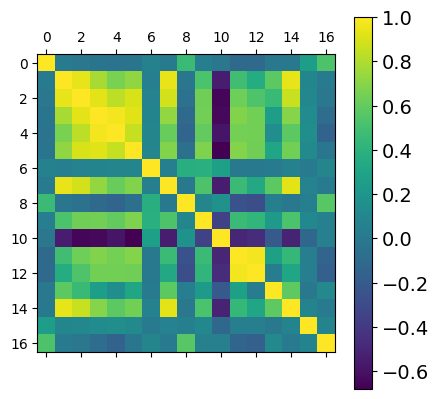

In [461]:
corr = X_train.corr()
corr.style.background_gradient(cmap='coolwarm')
plt.matshow(corr)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)

In [462]:
le = LabelEncoder()
le.fit(['Up', 'Down', 'Neutral'])
y_train = le.transform(y_train)
# y_valid = le.transform(y_valid)
y_test = le.transform(y_test)
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

In [463]:
# smote = SMOTE(random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [464]:
rus = RandomUnderSampler(random_state=42)
X_test, y_test = rus.fit_resample(X_test, y_test)

(array([4442., 4442., 4442.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

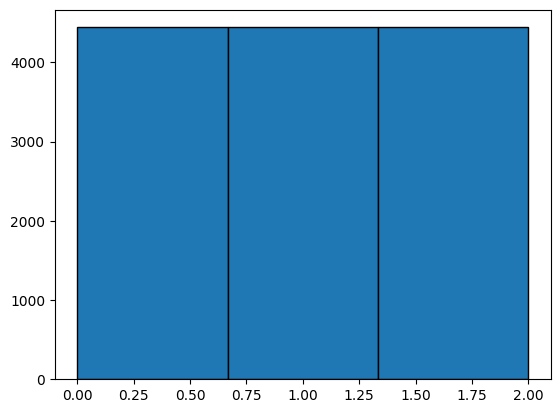

In [465]:
plt.hist(y_train, bins=3, edgecolor='black')

(array([444., 444., 444.]),
 array([0.        , 0.66666667, 1.33333333, 2.        ]),
 <BarContainer object of 3 artists>)

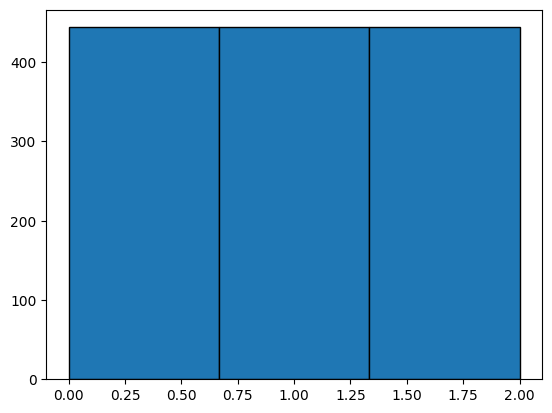

In [466]:
plt.hist(y_test, bins=3, edgecolor='black')

In [ ]:
%%time

param_grid = {
    'max_depth': [8],
    'learning_rate': [0.1],
    'n_estimators': [400, 425, 450],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8, 1.0],
}

model = xgb.XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')

# Thiết lập GridSearchCV
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Tối ưu hóa dựa trên accuracy
    n_jobs=3, 
    verbose=1
)

# Huấn luyện GridSearchCV
grid_search.fit(X_train, y_train)

# In tham số tốt nhất và điểm số
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 425, 'subsample': 0.8}
Best Cross-Validation Accuracy: 0.7411076091850517
CPU times: total: 40.8 s
Wall time: 3min 5s


In [468]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Test Accuracy: 0.7387

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.84      0.75       444
           1       0.78      0.69      0.73       444
           2       0.78      0.69      0.73       444

    accuracy                           0.74      1332
   macro avg       0.75      0.74      0.74      1332
weighted avg       0.75      0.74      0.74      1332


Confusion Matrix:
[[372  35  37]
 [ 87 305  52]
 [ 85  52 307]]


In [469]:
le.transform(['Up', 'Down', 'Neutral'])

array([2, 0, 1])

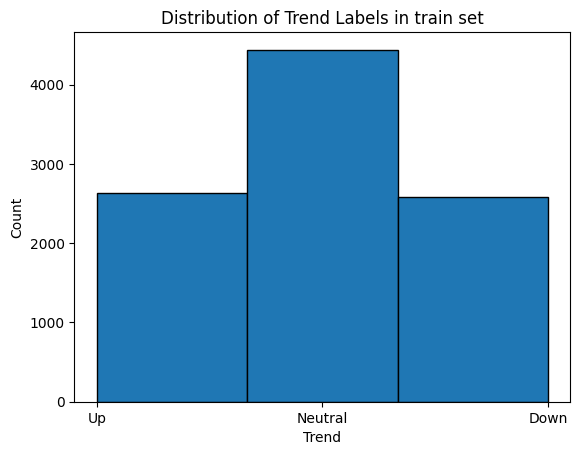

In [470]:
plt.hist(train_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in train set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

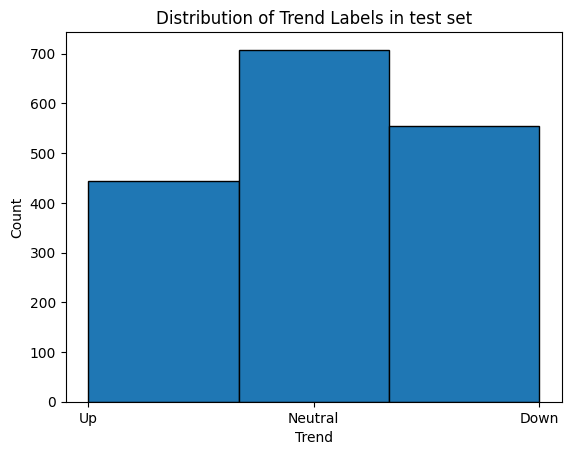

In [471]:
plt.hist(test_df['Trend'], bins=3, edgecolor='black')
plt.title('Distribution of Trend Labels in test set')
plt.xlabel('Trend')
plt.ylabel('Count')
plt.show()

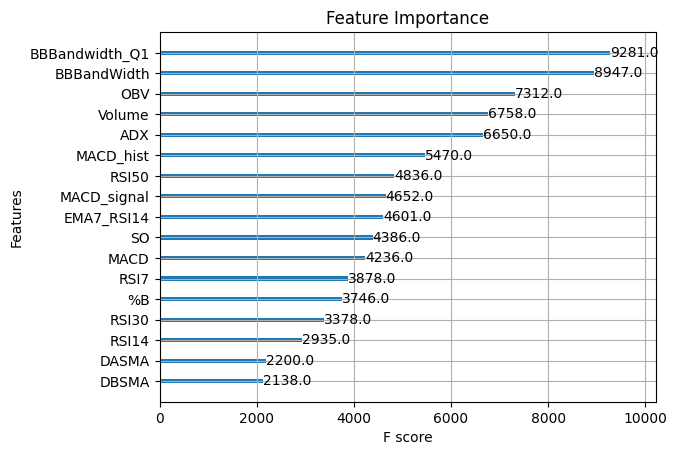

In [472]:
xgb.plot_importance(best_model)
plt.title('Feature Importance')
plt.show()